In [1]:
import numpy as np
from scipy.linalg import eig, eig_banded, eigh
from scipy.sparse.linalg import eigs, eigsh
from scipy.sparse import eye, diags
import kwant


import matplotlib.pyplot as plt

In [2]:
%%time
# N = 1000
# a = 0.1
# Emax = 1
# Emin = -1

# E_max_abs = np.max(np.abs([Emax, Emin]))

# H = diags(np.linspace(Emin, Emax, N))


N = 5000
c = np.random.rand(N-1) + np.random.rand(N-1)*1j
b = np.random.rand(N)
H = diags(c, offsets=-1) + diags(b, offsets=0) + diags(c.conj(), offsets=1)
Emin = eigsh(H, k=1, which='SA', return_eigenvectors=False)[0]
Emax = eigsh(H, k=1, which='LA', return_eigenvectors=False)[0]
E_max_abs = np.max(np.abs([Emax, Emin]))

a = 0.1

def G_operator(ham, Emax, Emin):
    Emax=Emax
    Emin=Emin
    E0 = (Emax - Emin)/2
    Ec = (Emax + Emin)/2
    return (ham - eye(ham.shape[0]) * Ec)/E0


def F_operator(ham, Emax, a):
    Emax=Emax
    E0 = (Emax**2 - a**2)/2
    Ec = (Emax**2 + a**2)/2
    return (ham @ ham - eye(ham.shape[0])*Ec)/E0

G = G_operator(H, Emax, Emin)
F = F_operator(H, E_max_abs, a)
a_r = a/E_max_abs


dos_estimate = kwant.kpm.SpectralDensity(
    H,
    energy_resolution=2*a,
    mean=True,
    bounds=(Emin, Emax)
)

d=int(np.abs(dos_estimate(0)*2*a))
d

CPU times: user 989 ms, sys: 7.7 ms, total: 997 ms
Wall time: 266 ms


227

In [3]:
def low_E_filter(ψ_rand, H, k):
    for i in range(k+1):
        if i == 0:
            ψ_n = ψ_rand
            continue
            
        if i == 1:
            ψ_nm1 = ψ_n
            ψ_n = H@ψ_nm1
            continue
            
        ψ_np1 = 2*H@ψ_n - ψ_nm1
        ψ_nm1 = ψ_n
        ψ_n = ψ_np1
        
    return ψ_n

def basis(ψ_proj, H, indices):
    ψ_basis = []
    k = indices[-1]
    for i in range(k):
        if i == 0:
            ψ_n = ψ_proj
            continue
            
        if i == 1:
            ψ_nm1 = ψ_n
            ψ_n = H@ψ_nm1
            continue
            
        ψ_np1 = 2*H@ψ_n - ψ_nm1
        ψ_nm1 = ψ_n
        ψ_n = ψ_np1
        
        if i+1 in indices:
            ψ_basis.append(ψ_n)
    return ψ_basis

CPU times: user 39.7 s, sys: 492 ms, total: 40.2 s
Wall time: 10.3 s


(-0.15000000000000002, 0.15000000000000002)

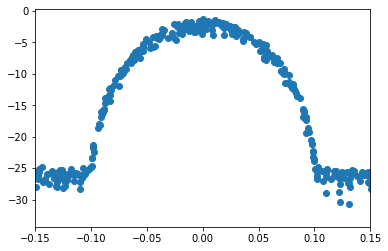

In [4]:
%%time
H_banded = np.array([[0, *c.conj()], [*b]])
true_eigvals, true_eigvecs = eig_banded(H_banded)
ψ_rand = np.random.rand(N) + np.random.rand(N)*1j
ψ_rand = ψ_rand/np.linalg.norm(ψ_rand)
ψ_proj = low_E_filter(ψ_rand, F, int(12*E_max_abs/a))
ψ_proj = ψ_proj/np.linalg.norm(ψ_proj)

plt.scatter(np.real(true_eigvals), np.log(np.abs(true_eigvecs.T.conj()@ψ_proj)))
plt.xlim([-a-a/2, a+a/2])

In [5]:
indx_proj = a >= np.abs(true_eigvals)
proj_eigvals = true_eigvals[indx_proj]
proj_eigvecs = true_eigvecs[:, indx_proj]

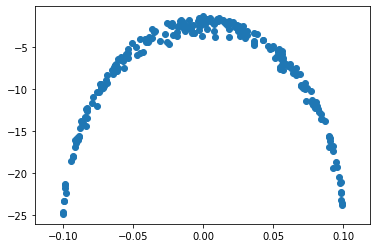

In [6]:
proj_density = np.log(np.abs(proj_eigvecs.T.conj()@ψ_proj))
plt.scatter(np.real(proj_eigvals), proj_density)

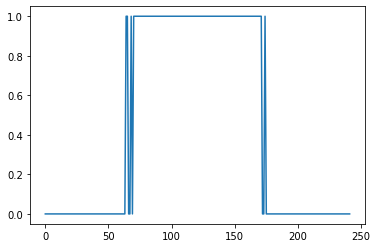

In [7]:
plt.plot(proj_density>-5)

In [8]:
%%time
n = int((d*3 - 1)/2)
n_array = np.arange(1, n+1, 1)
indicesp1 = n_array*(np.pi/a_r).astype(int)
indices = np.sort(np.array([*indicesp1, *indicesp1-1]))


ψ_basis = basis(ψ_proj, G, indices) ## The bottleneck step

norm = np.linalg.norm(ψ_basis, axis=1)
ψ_basis = ψ_basis/norm[:, np.newaxis]

CPU times: user 7.77 s, sys: 56 ms, total: 7.83 s
Wall time: 7.84 s


In [9]:
np.shape(ψ_basis)

(680, 5000)

In [10]:
np.shape(indices)

(680,)

In [11]:
np.shape(ψ_basis)

(680, 5000)

In [23]:
%%time
S = ψ_basis@ψ_basis.T.conj()
H_proj = ψ_basis@H@ψ_basis.T.conj()

CPU times: user 2.57 s, sys: 96 ms, total: 2.66 s
Wall time: 696 ms


In [24]:
%%time
s, V = eig(S)
indx = np.abs(s)>1e-12
lambda_s = np.diag(1/np.sqrt(s[indx]))
U = V[:, indx]@lambda_s

H_proj_red = U.T.conj()@H_proj@U

CPU times: user 4.43 s, sys: 39.8 ms, total: 4.47 s
Wall time: 1.13 s


In [25]:
np.shape(H_proj_red)

(215, 215)

In [26]:
%%time
# could use eigh, H_proj_red is approximately hermitian
eigvalues, eigvectors = eigh(H_proj_red)

CPU times: user 134 ms, sys: 4.17 ms, total: 139 ms
Wall time: 35.3 ms


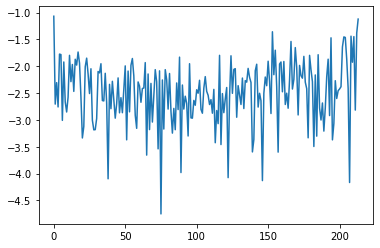

In [27]:
plt.plot(np.log10(np.diff(np.sort(np.real(eigvalues)))))

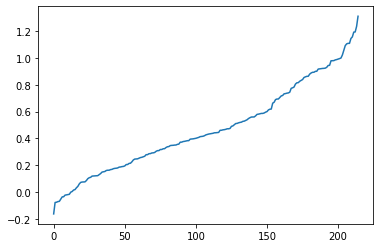

In [28]:
plt.plot(np.sort(np.real(eigvalues)))

In [29]:
E0 = (Emax - Emin)/2
Ec = (Emax + Emin)/2
print(E0)
print(Ec)

2.304432554147798
0.5465482405019196


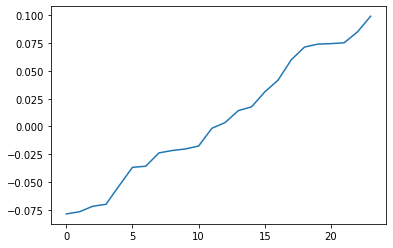

In [30]:
out_indx = a >= np.abs(eigvalues)
plt.plot(np.sort(np.real(eigvalues[out_indx])))

(-0.1, 0.1)

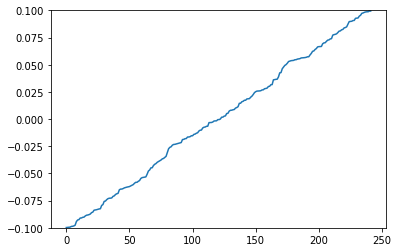

In [31]:
out_indx = a >= np.abs(true_eigvals)
plt.plot(np.sort(np.real(true_eigvals[out_indx])))
plt.ylim([-a,a])

In [12]:
import kwant

dos = kwant.kpm.SpectralDensity(
    H_proj_red,
    mean=True,
    bounds=(-a, a),
    energy_resolution=0.005
)

/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


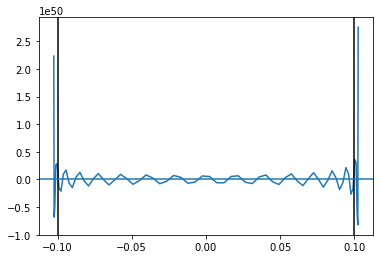

In [13]:
plt.plot(*dos())
plt.axvline(-a, c='k')
plt.axvline(a, c='k')
# plt.xlim(-a, a)
# plt.ylim(-1e59, 1e59)
plt.axhline(0)
plt.show()